# Import Lib

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout,  Activation, Flatten, Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential

from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow import keras
import plotly.graph_objects as go

from google.colab import drive
import os

# PATH

In [2]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/')

project_path = "Report_DBA/"
source_path = project_path + "source/"
data_path = project_path + "data/BTC-USD.csv"

Mounted at /content/drive/


In [3]:
df = pd.read_csv(data_path)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1822,04/22/2023,27265.89453,27872.14258,27169.57031,27817.50000,27817.50000,1.312573e+10
1823,04/23/2023,27816.14453,27820.24414,27400.31445,27591.38477,27591.38477,1.278545e+10
1824,04/24/2023,27591.73047,27979.98242,27070.84961,27525.33984,27525.33984,1.770329e+10
1825,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1826,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   Open       1825 non-null   float64
 2   High       1825 non-null   float64
 3   Low        1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Adj Close  1825 non-null   float64
 6   Volume     1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 100.0+ KB


Nhận thấy dữ liệu có 1827 dòng nhưng có 2 dòng bị thiếu ==> Vậy nên cần xử lý các dòng đó

In [5]:
# do 2 dòng này nằm cuối dữ liệu nên không cần tìm giá trị thay thế mà trực tiếp loại bỏ
df.dropna(inplace=True)

# Plot

In [6]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

# Train Test vs Validation Split

In [7]:
n_observations = df.shape[0]
features = ["Open", "High", "Low", "Volume", "Adj Close"]

df = df[ features]
train = df[:int(n_observations*0.7)]
test = df[int(n_observations*0.7): int(n_observations*0.9)]
val = df[int(n_observations*0.9):]

# Helper Functions

In [8]:
def to_supervised(data, lookback = 3):
    n = data.shape[0]
    X, y = list(), list()
    for i in range(n - lookback):
        X.append(data[i: i + lookback])
        y.append(data[i+lookback, -1])
    return np.array(X), np.array(y)

# Main Run

## Prepare data

In [9]:
scaler = MinMaxScaler().fit(train)
y_scaler = MinMaxScaler().fit(train.values[:, -1].reshape(-1, 1))
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
val_scaled = scaler.transform(val)

train_X, train_y= to_supervised(train_scaled, 3)
test_X, test_y = to_supervised(test_scaled, 3)
val_X, val_y = to_supervised(val_scaled, 3)

## CNN Model

In [10]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(3, 5)))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))

cnn_model.compile(loss='mse',
                  optimizer='adam',
                   metrics=[
                       'mae', tf.keras.metrics.RootMeanSquaredError() , 'mape'
                   ])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             704       
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 50)                6450      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7,205
Trainable params: 7,205
Non-trainable params: 0
_________________________________________________________________


## Train data

In [16]:
history = cnn_model.fit(train_X, train_y, 
          epochs=350, 
          batch_size=32, 
          validation_data=(val_X, val_y))

Epoch 1/350
40/40 [==============================] - 0s 10ms/step - loss: 2.7570e-04 - mae: 0.0091 - root_mean_squared_error: 0.0166 - mape: 613.4573 - val_loss: 1.2729e-04 - val_mae: 0.0082 - val_root_mean_squared_error: 0.0113 - val_mape: 2.8263
Epoch 2/350
40/40 [==============================] - 0s 7ms/step - loss: 2.3384e-04 - mae: 0.0079 - root_mean_squared_error: 0.0153 - mape: 1187.7423 - val_loss: 1.4326e-04 - val_mae: 0.0090 - val_root_mean_squared_error: 0.0120 - val_mape: 3.1140
Epoch 3/350
40/40 [==============================] - 0s 8ms/step - loss: 2.3116e-04 - mae: 0.0080 - root_mean_squared_error: 0.0152 - mape: 735.0267 - val_loss: 1.4028e-04 - val_mae: 0.0089 - val_root_mean_squared_error: 0.0118 - val_mape: 3.1016
Epoch 4/350
40/40 [==============================] - 0s 7ms/step - loss: 2.2454e-04 - mae: 0.0079 - root_mean_squared_error: 0.0150 - mape: 394.4963 - val_loss: 1.0831e-04 - val_mae: 0.0073 - val_root_mean_squared_error: 0.0104 - val_mape: 2.4724
Epoch 5/35

## Test data

12/12 [==============================] - 0s 2ms/step


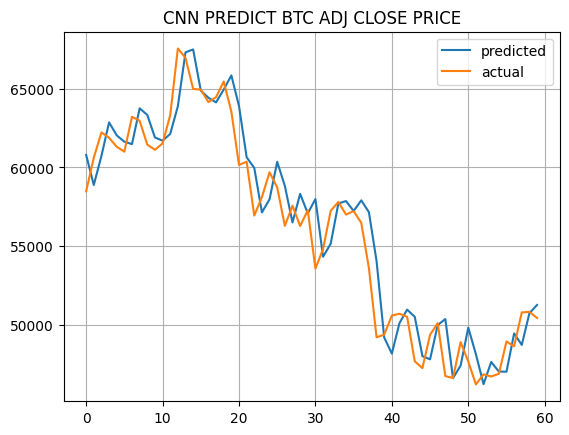

In [17]:
# number of days used for flotting
days = 60

pred = cnn_model.predict(test_X)

# inverse data to origin values
y_predicted = y_scaler.inverse_transform(np.array(pred).reshape(-1, 1)).reshape(-1, )
y_true = y_scaler.inverse_transform(np.array(test_y).reshape(-1, 1)).reshape(-1, )

# plot
plt.grid(True)
plt.plot(y_predicted[:days], label="predicted")
plt.plot(y_true[:days], label="actual")
plt.title("CNN PREDICT BTC ADJ CLOSE PRICE")
plt.legend()
plt.show()

# Evaluate


In [18]:
mae = mean_absolute_error(y_true, y_predicted)
rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
mape = mean_absolute_percentage_error(y_true, y_predicted)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"mape: {mape}")

MAE: 967.5358949395717
RMSE: 1350.3088850305803
mape: 0.028600632650527563
